# Homework 1 MA course in Artificial Intelligence 2022/2023



In [ ]:
!rm -r AI2022MA
!git clone https://github.com/UmbertoJr/AI2022MA.git

Cloning into 'AI2022MA'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 213 (delta 103), reused 159 (delta 49), pack-reused 0
Receiving objects: 100% (213/213), 3.48 MiB | 8.85 MiB/s, done.
Resolving deltas: 100% (103/103), done.


# Iterated Local Search for the Travelling Salesman Problem

Let's read the standard TSP instance called 'd198.tsp'

name: d198
nPoints: 198
best_sol: 15780.0


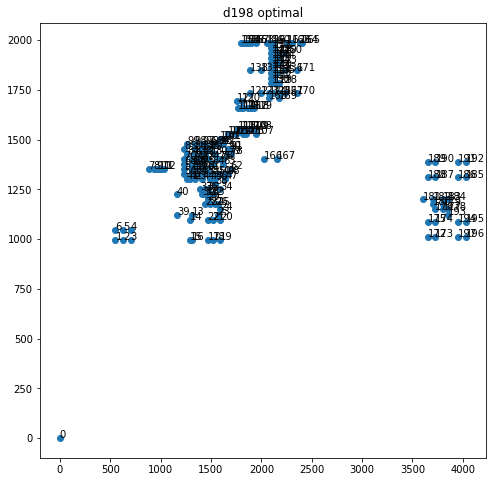

In [ ]:
#from IO_manager.io_tsp import TSP_Instance_Creator
# if you are running not from your local add the prefix AI2022MA (comment the previous line and uncomment the following line)
from AI2022MA.IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

## 2-opt

&nbsp;

Here is an example of how to use our black-box 2-opt implementation. As you saw in ["Introduction to the TSP"](https://colab.research.google.com/github/UmbertoJr/AI2020/blob/master/introduction_to_the_TSP.ipynb#scrollTo=4aGR4Nus83wa), the meta-heuristics must respect the input and output format shown in the notebook!

An example of a meta-heuristics format is the shown **naive_heuristic**, where the TwoOpt.local_search is used to improve the solution.

Note that the yield and the ending condition (ending_cond) are used by the Solver_TSP class to break the running after 3 minutes or when the local search is completed.




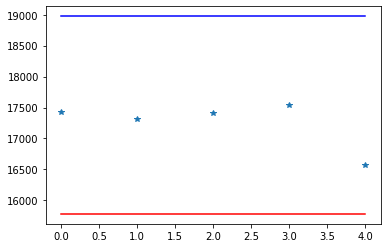

best gap with NN 20.25% on 1 trial,
with a total time of 0.004 seconds

best gap with random + 2opt 4.99% on 5 trials,
with a total time of 1.77 seconds


In [ ]:
import numpy as np
from time import time as t
import matplotlib.pyplot as plt

#from solvers.local_search import TwoOpt
#from solvers.TSP_solver import Solver_TSP
#from solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
# if you are not running from your local, add the prefix AI2021MA (comment the previous 3 lines and use instead the following 3 lines)
from AI2022MA.solvers.local_search import TwoOpt
from AI2022MA.solvers.TSP_solver import Solver_TSP
from AI2022MA.solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor

def naive_heuristic(solution, cost_sol, dist_matrix):
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data
    yield  new_solution, new_cost, number_calls_ls, ending_cond

number_of_trials = 5
found_lens = []
start = t()
solver = Solver_TSP(('random', Random_Initializer.random_method))
solver.bind(('naive heuristic', naive_heuristic ))

for _ in range(number_of_trials):
  solver(ic)
  found_lens.append(solver.found_length)
end = t()

solver = Solver_TSP(('nearest neighbor', Nearest_Neighbor.nn))
solver(ic)

plt.plot(found_lens, "*")
plt.plot(np.ones(number_of_trials)*ic.best_sol, "r-")
plt.plot(np.ones(number_of_trials)*solver.found_length, "b-")
plt.show()
print(f"best gap with NN {solver.gap}% on 1 trial,\nwith a total time of {np.round(solver.time_to_solve, 5)} seconds")
print()
print(f"best gap with random + 2opt {np.round(100*(min(found_lens) - ic.best_sol)/ic.best_sol, 2)}% on {number_of_trials} trials,\nwith a total time of {np.round(end - start, 2)} seconds")

## Double Bridge

Here you need to implement your own Double Bridge permutation!

In [ ]:
import random

class DoubleBridge:
    @staticmethod
    def difference_cost(solution, a, b, c, d, matrix):
        #Calculate the difference in cost of the two solutions
        return matrix[solution[a-1]][solution[b]] + matrix[solution[c-1]][solution[d]] - matrix[solution[a-1]][solution[c-1]] - matrix[solution[b]][solution[d]]

    @staticmethod
    def perturb_solution(solution, actual_cost, matrix):
        #generate random permutation
        a, b, c, d = random.sample(range(0, len(solution)), 4)
        while a == b or a == c or a == d or b == c or b == d or c == d:
          a, b, c, d = random.sample(range(0, len(solution)), 4)

        a, b, c, d = sorted([a, b, c, d])
        #print(a,b,c,d)

        #swap values
        solution = np.concatenate((solution[:a], solution[b:c+1], solution[a:b],solution[c+1:]))

        #calculate new cost
        new_cost = actual_cost + DoubleBridge.difference_cost(solution, a, b, c, d, matrix)
        return solution, new_cost

In [ ]:
#from solvers.constructive_algorithms import compute_length
# if you are not running from your local, add the prefix AI2022MA (comment the previous line and uncomment the following line)
from AI2022MA.solvers.constructive_algorithms import compute_length

# example perturbation
case_solution = np.arange(12)
matrix = np.random.rand(12, 12)
cost = compute_length(case_solution, matrix)
print(case_solution, cost)

new_sol, new_length = DoubleBridge.perturb_solution(case_solution, cost, matrix)
print(new_sol, new_length)

[ 0  1  2  3  4  5  6  7  8  9 10 11] 6.900815625229109
[ 0  2  3  1  4  5  6  7  8  9 10 11] 6.900815625229109


## Iterated Local Search


Here you need to implement the three variants of the ILS we saw earlier in class.

To boost the time performances please use the cython class **two_opt_with_candidate**.

In [ ]:
#from solvers.local_search import TwoOpt
#from solvers.two_opt_with_candidate import twoOpt_with_cl
# if you are not running from your local, add the prefix AI2022MA (comment the previous lines and uncomment the following lines)
from AI2022MA.solvers.local_search import TwoOpt
from AI2022MA.solvers.two_opt_with_candidate import twoOpt_with_cl

cost_sol_better = []
cost_sol_RW = []
cost_sol_LSMC = []

def my_local_search(solution, cost_sol, dist_matrix):
  new_solution, new_cost = solution, cost_sol
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data
  return new_solution, new_cost

def generate_cl(dist_matrix):
  n = dist_matrix.shape[0]
  cl = np.zeros((n, 20))
  for i in range(n):
    cl[i] = np.argsort(dist_matrix[i, :])[1: 21]
  return cl

class ILS_Better:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_better
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    """
    #  in case you want to use twoOpt_with_cl
    cl = generate_cl(matrix) # remember you don't need to compute the cl each time
    new_sol, new_cost = twoOpt_with_cl(solution, actual_cost, matrix, cl)
    """
    best_sol,best_cost = new_sol, new_cost
    cost_sol_better.append(new_cost)
    ls_calls = 1
    while True:
      # implement perturbation
        new_sol, new_cost = DoubleBridge.perturb_solution(new_sol, new_cost, matrix)
        new_sol, new_cost = my_local_search(new_sol, new_cost, matrix)
      #implement aceptance criterion
        if new_cost < best_cost:
            best_sol, best_cost = new_sol, new_cost
            cost_sol_better.append(new_cost)
        ls_calls += 1
        yield best_sol, best_cost, ls_calls, False

class ILS_RW:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_RW
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_RW.append(new_cost)
    ls_calls = 1
    while True:
      # implement perturbation
        new_sol, new_cost = DoubleBridge.perturb_solution(new_sol, new_cost, matrix)
        new_sol, new_cost = my_local_search(new_sol, new_cost, matrix)
      #implement aceptance criterion
        best_sol, best_cost = new_sol, new_cost
        cost_sol_RW.append(new_cost)
        ls_calls += 1
        yield best_sol, best_cost, ls_calls, False

class ILS_LSMC:
  @staticmethod
  def acceptance_criterion(best_cost, new_cost, temperature):
    return

  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_LSMC
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_LSMC.append(new_cost)
    ls_calls = 1
    temperature=100.
    while True:
      # implement perturbation
        new_sol, new_cost = DoubleBridge.perturb_solution(new_sol, new_cost, matrix)
        new_sol, new_cost = my_local_search(new_sol, new_cost, matrix)
      #implement aceptance criterion

        if new_cost < best_cost or random.random() < np.exp((best_cost - new_cost)/temperature):
          best_sol, best_cost = new_sol, new_cost
          cost_sol_LSMC.append(new_cost)
        ls_calls += 1
        temperature*=0.95
        yield best_sol, best_cost, ls_calls, False


### Example of Table

Take care that you need to change the code in order to satisfy the requirements for the task!

In [ ]:
import pandas as pd

seeds= [0, 123, 333]
time_to_solve = 30 # in seconds

#names_instances = ["d198.tsp"] #, "pr439.tsp", "u1060.tsp"
names_instances = ["d198.tsp", "pr439.tsp", "u1060.tsp"]

samples = {name:{} for name in names_instances}
collectors = [cost_sol_better, cost_sol_RW, cost_sol_LSMC]
initializers = ["random"]
init_functions = [Random_Initializer.random_method]
improvements = ["ILS-better","ILS-RW","ILS-LSMC"]
improve_functions = [ILS_Better.solve, ILS_RW.solve, ILS_LSMC.solve]
results = []
index = []
for s_ in seeds:
  for i, init in enumerate(initializers):
    for j, improve in enumerate(improvements):
      solver = Solver_TSP((init, init_functions[i]), seed_=s_, stop_run_after=time_to_solve)
      solver.bind((improve, improve_functions[j]))
      for name in names_instances:
        instance = TSP_Instance_Creator("standard", name)
        solver(instance)
        index.append((name, instance.best_sol, solver.name_method, s_))
        results.append([solver.found_length, solver.gap, solver.time_to_solve, solver.ls_calls])
        samples[name][improve] = np.round(np.abs(np.array(collectors[j]) - ic.best_sol)/ic.best_sol * 100, 2)
        if j == 0:
           cost_sol_better = []
        elif j == 1:
           cost_sol_RW = []
        else:
           cost_sol_LSMC = []

index = pd.MultiIndex.from_tuples(index, names=['problem','optimal length', 'method', 'seed'])

pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls Local Search"])

,,,,tour length,gap,time to solve,calls Local Search
problem,optimal length,method,seed,,,,
d198.tsp,15780.0,"initialized with random, improved with ILS-better",0,16922.0,7.24,30.053,103
pr439.tsp,107217.0,"initialized with random, improved with ILS-better",0,121133.0,12.98,30.597,26
u1060.tsp,224094.0,"initialized with random, improved with ILS-better",0,248211.0,10.76,33.362,3
d198.tsp,15780.0,"initialized with random, improved with ILS-RW",0,16729.0,6.01,30.034,156
pr439.tsp,107217.0,"initialized with random, improved with ILS-RW",0,120792.0,12.66,30.590,26
u1060.tsp,224094.0,"initialized with random, improved with ILS-RW",0,254081.0,13.38,33.375,4
d198.tsp,15780.0,"initialized with random, improved with ILS-LSMC",0,18180.0,15.21,30.097,152
pr439.tsp,107217.0,"initialized with random, improved with ILS-LSMC",0,117742.0,9.82,30.316,26
u1060.tsp,224094.0,"initialized with random, improved with ILS-LSMC",0,253049.0,12.92,32.591,3


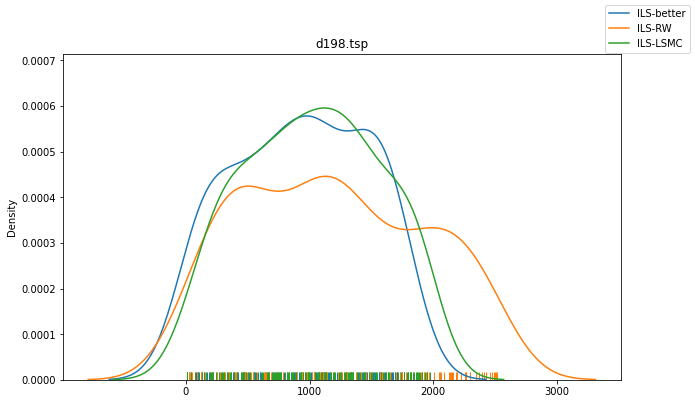

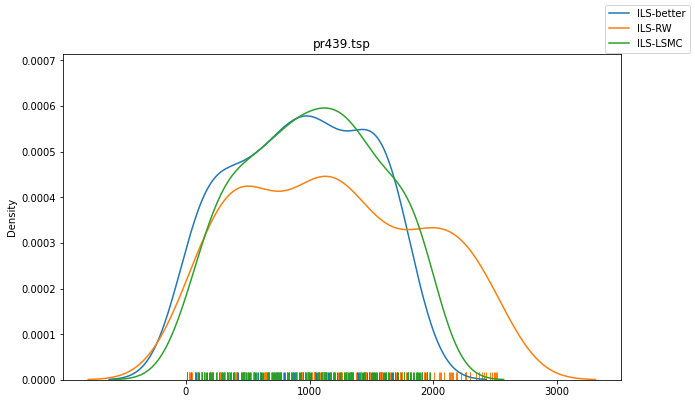

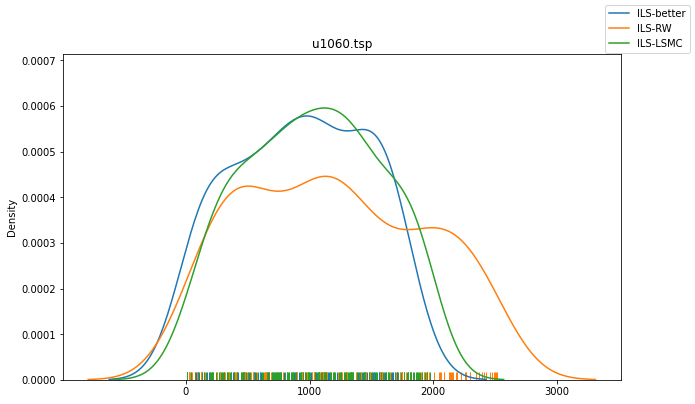

In [ ]:
import warnings
import seaborn as sns

with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  for instance in names_instances:
    fig = plt.figure(figsize=(10,6))
    for j, improve in enumerate(improvements):
      sns.distplot(samples[instance][improve], rug=True, hist=False)

    fig.legend(labels=improvements)
    plt.title(instance)
    plt.show()